<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/06_05_HistoryMatching_CumOil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install jcopml

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [202]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/03_Training_df2.csv')

In [203]:
df.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0.000000,0.0,0,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,0.084932,26614.0,825035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83000 entries, 0 to 82999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   case_num        83000 non-null  int64  
 1   days            83000 non-null  int64  
 2   years           83000 non-null  float64
 3   oil_prod_rate   83000 non-null  float64
 4   oil_prod_cum    83000 non-null  int64  
 5   water_inj_rate  83000 non-null  float64
 6   water_inj_cum   83000 non-null  float64
 7   category        83000 non-null  object 
 8   Kh_Kv           83000 non-null  float64
 9   inj_rate        83000 non-null  float64
 10  permeability    83000 non-null  float64
 11  porosity        83000 non-null  float64
 12  prod_bhp        83000 non-null  float64
 13  thickness       83000 non-null  float64
dtypes: float64(10), int64(3), object(1)
memory usage: 8.9+ MB


In [205]:
df.set_index('case_num', inplace=True)

In [206]:
X = df.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category'])
y = df.oil_prod_cum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

In [211]:
X.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,
0,0.000000,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.084932,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.169863,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.254795,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.339726,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [212]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [213]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson'), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=20, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


{'algo__max_depth': 69, 'algo__max_features': 0.6962700559185838, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 105}
0.9999077555069658 0.9993898076206112 0.9996775914984394


In [214]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd.pkl']

In [215]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF.best_estimator_, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best.pkl']

In [216]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best.pkl'

import joblib

# Load the specific model
model_RF = joblib.load(file_path)

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

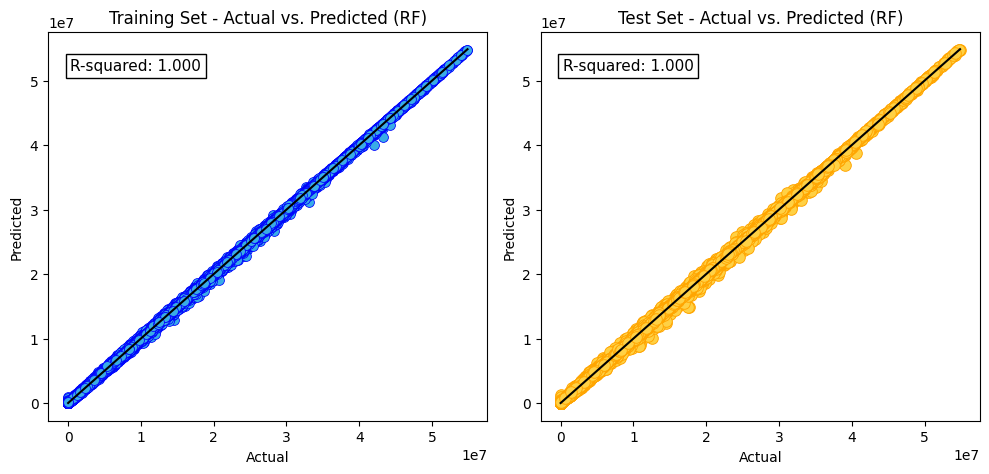

In [222]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='blue')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='orange')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

#**TEST DATA PREDICTION**

In [12]:
# Obtain predictions for the test dataset
y_test_pred = model_RF.predict(X_test)

In [14]:
comparison_test_df = pd.DataFrame({'Predicted': y_test_pred, 'Actual': y_test})
comparison_test_df.head()

,Predicted,Actual
case_num,,
588,7905.944103,7782.62
391,2463.340069,2457.39
773,5642.163500,5126.19
775,1461.539027,1467.06
879,10942.997035,10041.70


In [15]:
# Concatenate comparison_df with X_test
concatenated_test_df = pd.concat([X_test, comparison_test_df], axis=1)

concatenated_test_df.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
case_num,,,,,,,,,
588,1.358904,55.671093,1072.948149,322.005237,0.296478,974.812075,21.998831,7905.944103,7782.62
391,6.200000,17.743045,1327.831513,230.685909,0.298417,459.303415,93.661558,2463.340069,2457.39
773,1.528767,91.594717,1210.373574,496.644528,0.243255,763.475551,31.259883,5642.163500,5126.19
775,4.416438,6.324609,1251.987121,329.811040,0.235667,786.512041,38.828670,1461.539027,1467.06
879,1.189041,84.097055,2424.864587,251.993775,0.136780,866.797466,56.402386,10942.997035,10041.70


#**TRAINING DATA PREDICTION**

In [16]:
# Obtain predictions for the training dataset
y_train_pred = model_RF.predict(X_train)

In [17]:
comparison_train_df = pd.DataFrame({'Predicted': y_train_pred, 'Actual': y_train})
comparison_train_df.head()

,Predicted,Actual
case_num,,
207,1334.917542,1325.52
779,32425.678949,31759.10
783,2612.355729,2617.35
638,2127.240878,2130.44
138,1570.055084,1571.16


In [18]:
# Concatenate comparison_df with X_train
concatenated_train_df = pd.concat([X_train, comparison_train_df], axis=1)

concatenated_train_df.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
case_num,,,,,,,,,
207,4.756164,53.430458,1164.225717,210.578313,0.169661,513.893676,34.327362,1334.917542,1325.52
779,0.169863,30.180537,1683.703882,293.308471,0.159314,472.891708,32.006569,32425.678949,31759.10
783,3.227397,42.195767,1491.226913,393.795810,0.232694,521.133493,86.997859,2612.355729,2617.35
638,6.030137,62.283845,1887.808774,276.374370,0.267304,424.747788,53.609024,2127.240878,2130.44
138,4.756164,23.878544,1525.459004,405.047106,0.184826,513.829693,78.662629,1570.055084,1571.16


#**DATASET PREDICTION**

In [223]:
df_pred = model_RF.predict(X)

In [224]:
df_predict = pd.DataFrame({'Predicted': df_pred, 'Actual': y})

In [225]:
df_prediction = pd.concat([X, df_predict], axis=1)

In [226]:
df_prediction.tail()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
case_num,,,,,,,,,
999,6.624658,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681,2.558992e+07,25627800
999,6.709589,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681,2.570645e+07,25699600
999,6.794521,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681,2.574979e+07,25770900
999,6.879452,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681,2.576333e+07,25841600
999,6.964384,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681,2.576460e+07,25911900


In [227]:
df_prediction = df_prediction.reset_index(drop = False)

In [228]:
# Get unique values in the "case_num" column
unique_cases = df_prediction['case_num'].unique()

# Initialize an empty DataFrame to store the sorted data
df_prediction2 = pd.DataFrame()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    case_data = df_prediction[df_prediction['case_num'] == case]
    # Sort the data based on the "days" column
    sorted_case_data = case_data.sort_values(by="years")
    # Drop the first row from the sorted data
    sorted_case_data = sorted_case_data.drop(sorted_case_data.index[0])
    # Append the sorted data to the overall sorted DataFrame
    df_prediction2 = pd.concat([df_prediction2, sorted_case_data], ignore_index=True)


In [229]:
df_prediction2.loc[df_prediction['case_num'] == 12].tail()

,case_num,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
1074,13,0.764384,81.656518,1244.689219,201.998281,0.266884,607.01423,17.833764,3.504005e+06,3342290
1075,13,0.849315,81.656518,1244.689219,201.998281,0.266884,607.01423,17.833764,3.736767e+06,3620230
1076,13,0.934247,81.656518,1244.689219,201.998281,0.266884,607.01423,17.833764,3.944714e+06,3884440
1077,13,1.019178,81.656518,1244.689219,201.998281,0.266884,607.01423,17.833764,4.180596e+06,4135710
1078,13,1.104110,81.656518,1244.689219,201.998281,0.266884,607.01423,17.833764,4.392416e+06,4374810


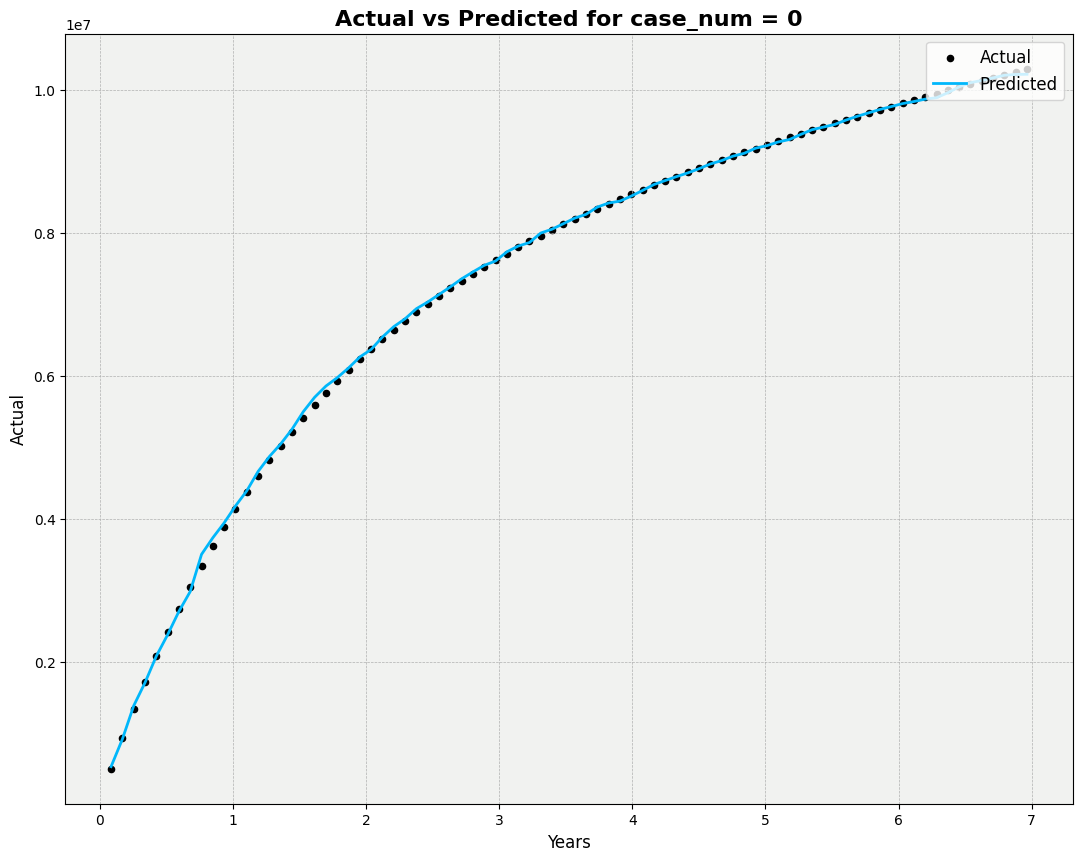

In [232]:
import matplotlib.pyplot as plt

plot_1 = df_prediction2[df_prediction2['case_num'] == 13]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='#00b7fb', linewidth=2, label='Predicted')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

#**VALIDATION**

In [295]:
df_validation = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/04_Validation_df2.csv')

In [296]:
df_validation.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,2573,7.049315,1790.12,10181500,1740.71,4478850.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,2604,7.134247,1790.09,10237000,1740.71,4532810.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,2635,7.219178,1790.07,10292500,1740.71,4586770.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,2666,7.304110,1790.03,10348000,1740.71,4640740.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,2697,7.389041,1789.99,10403500,1740.71,4694700.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [297]:
pred = df_validation.copy()

In [298]:
pred.drop(columns = ['days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category', 'oil_prod_rate' ], inplace = True)

In [299]:
pred.set_index('case_num', inplace=True)
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   years         38000 non-null  float64
 1   Kh_Kv         38000 non-null  float64
 2   inj_rate      38000 non-null  float64
 3   permeability  38000 non-null  float64
 4   porosity      38000 non-null  float64
 5   prod_bhp      38000 non-null  float64
 6   thickness     38000 non-null  float64
dtypes: float64(7)
memory usage: 2.3 MB


In [274]:
X.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,
0,0.000000,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.084932,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.169863,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.254795,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.339726,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [300]:
pred.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,
0,7.049315,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.134247,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.219178,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.304110,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.389041,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [301]:
y_pred = model_RF.predict(pred)

In [302]:
R2_score = r2_score(df_validation.oil_prod_cum, y_pred)
R2_score

0.9712343772426342

In [313]:
val_pred = df_validation.copy()
val_pred['Predicted_cum_oil'] = y_pred

In [319]:
val_pred[val_pred['case_num'] == 10].head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted_cum_oil
380,10,2573,7.049315,2984.34,21128300,1039.5,2674640.0,train,45.562823,1039.504281,88.312606,0.262261,566.346366,50.182736,2.089849e+07
381,10,2604,7.134247,2933.26,21219200,1039.5,2706870.0,train,45.562823,1039.504281,88.312606,0.262261,566.346366,50.182736,2.089849e+07
382,10,2635,7.219178,2883.54,21308600,1039.5,2739090.0,train,45.562823,1039.504281,88.312606,0.262261,566.346366,50.182736,2.089849e+07
383,10,2666,7.304110,2835.14,21396500,1039.5,2771320.0,train,45.562823,1039.504281,88.312606,0.262261,566.346366,50.182736,2.089849e+07
384,10,2697,7.389041,2788.02,21482900,1039.5,2803540.0,train,45.562823,1039.504281,88.312606,0.262261,566.346366,50.182736,2.089849e+07


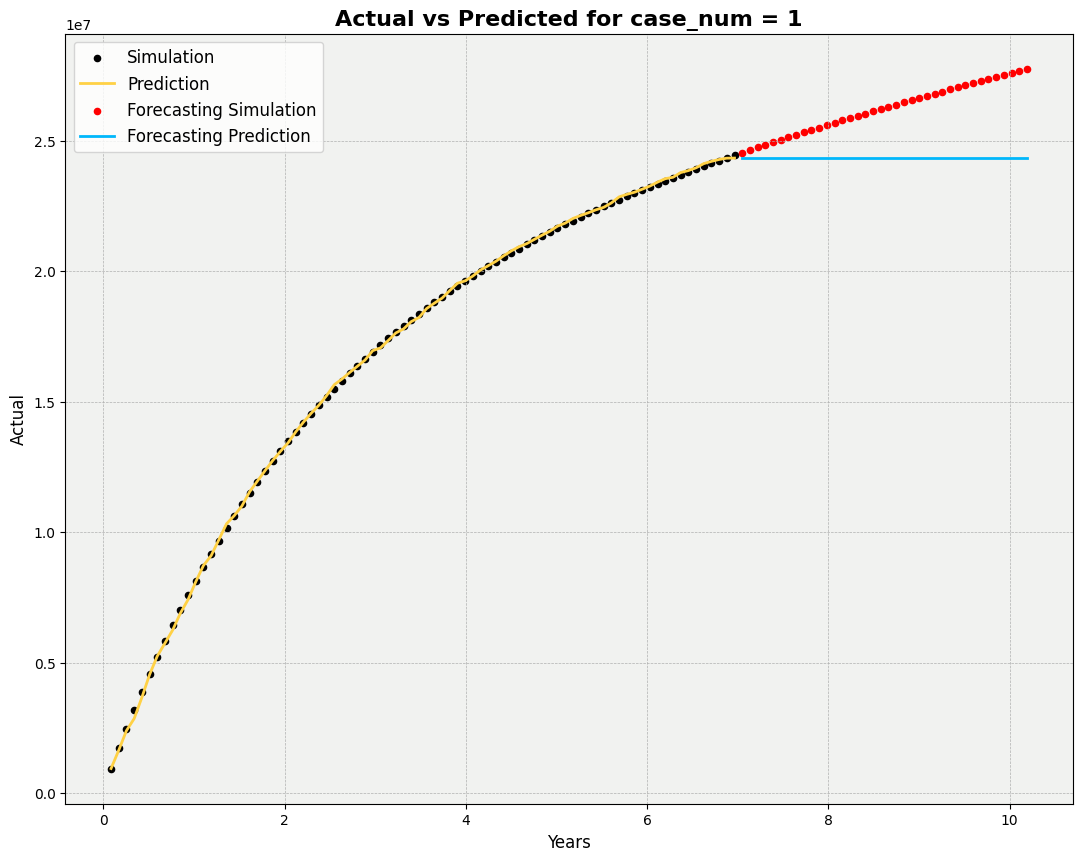

In [320]:
plot_1 = df_prediction2[df_prediction2['case_num'] == 1]
plot_2 = val_pred[val_pred['case_num'] == 1]

case_num_value = plot_1['case_num'].unique()[0]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot1 scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Simulation', marker='o')

# Plot1 line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='#ffd145', linewidth=2, label='Prediction')


# Plot2 scatter for "Actual" column
ax1.scatter(plot_2['years'], plot_2['oil_prod_cum'], color='red', s=20, label='Forecasting Simulation', marker='o')

# Plot2 line for "Predicted" column
ax1.plot(plot_2['years'], plot_2['Predicted_cum_oil'], color='#00b7fb', linewidth=2, label='Forecasting Prediction')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title(f'Actual vs Predicted for case_num = {case_num_value}', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper left', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

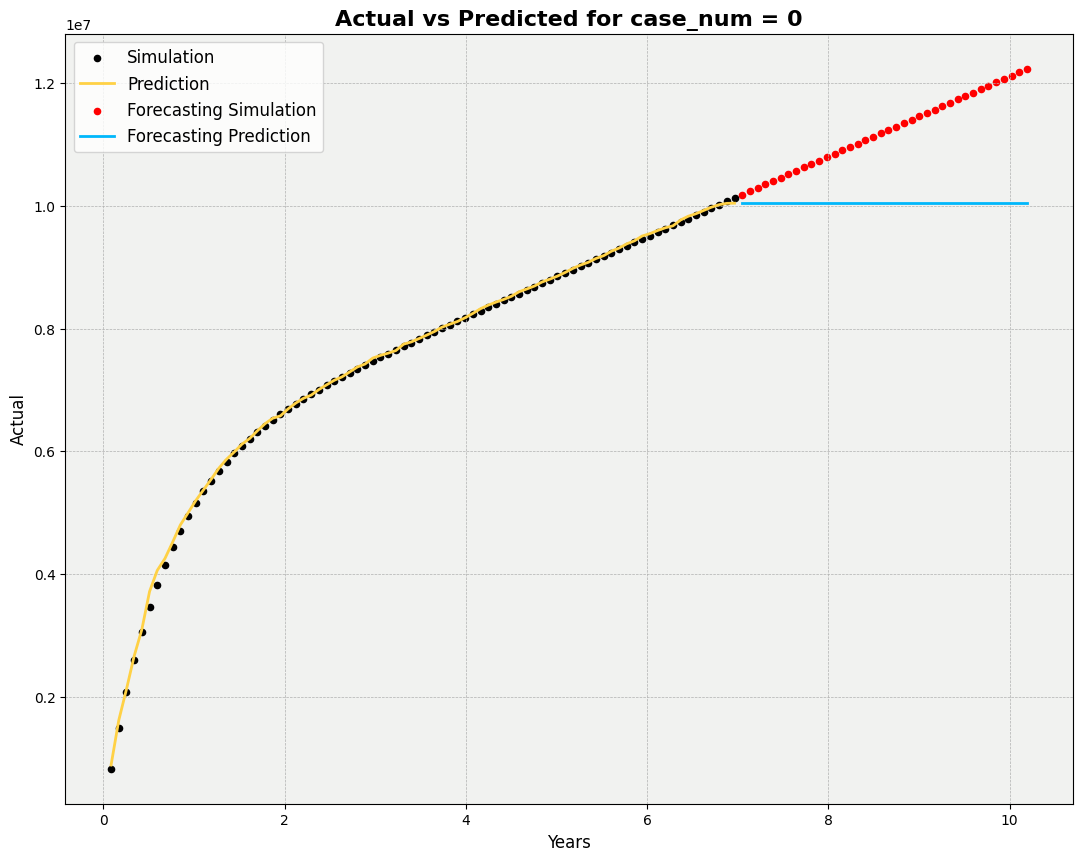

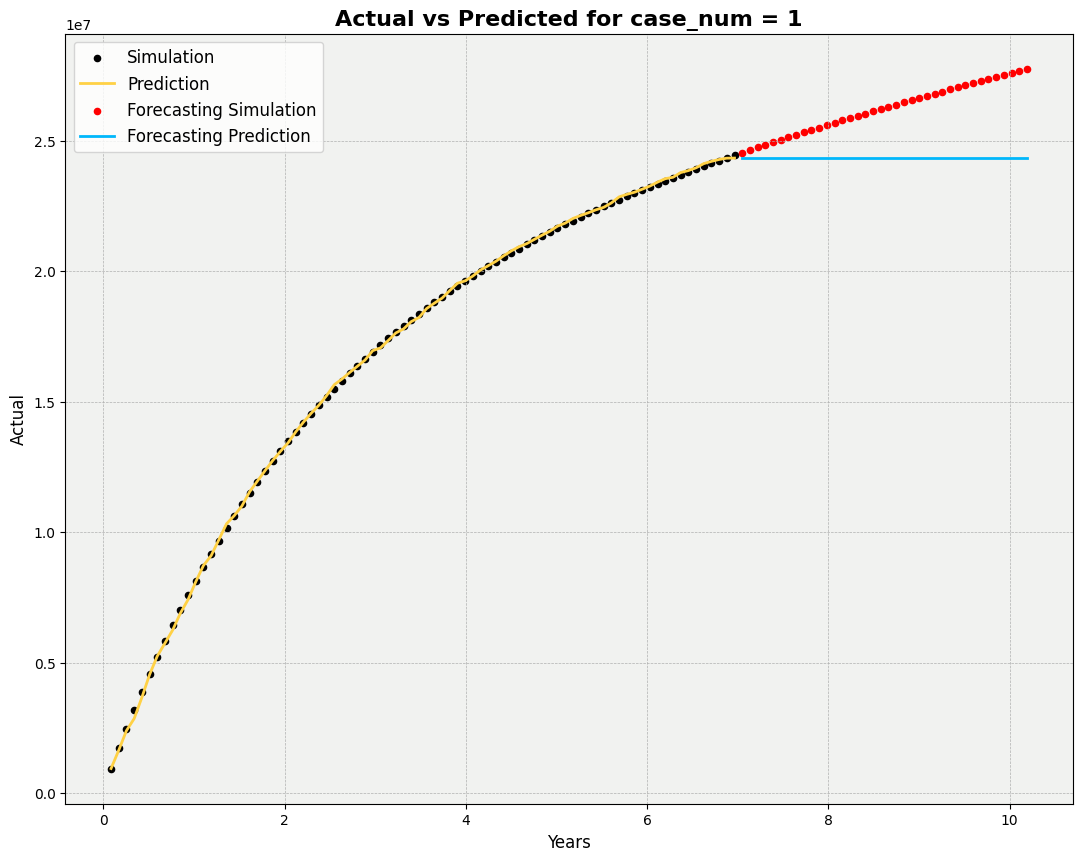

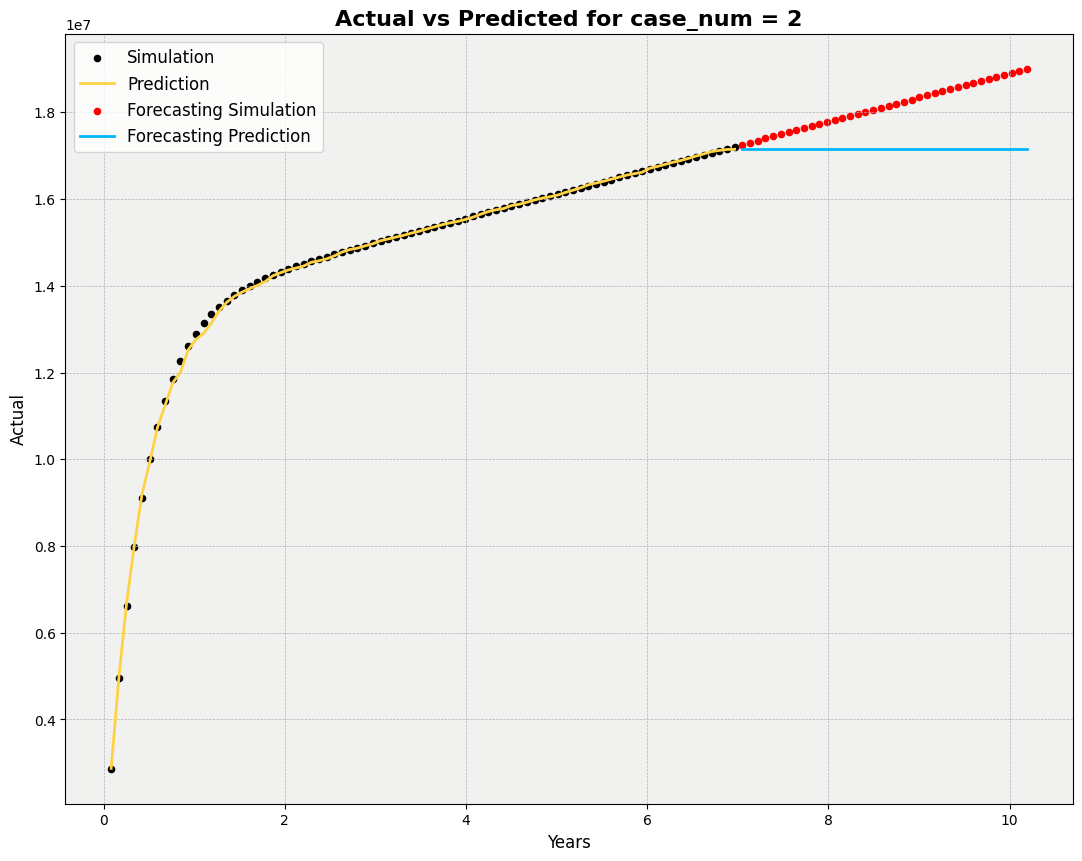

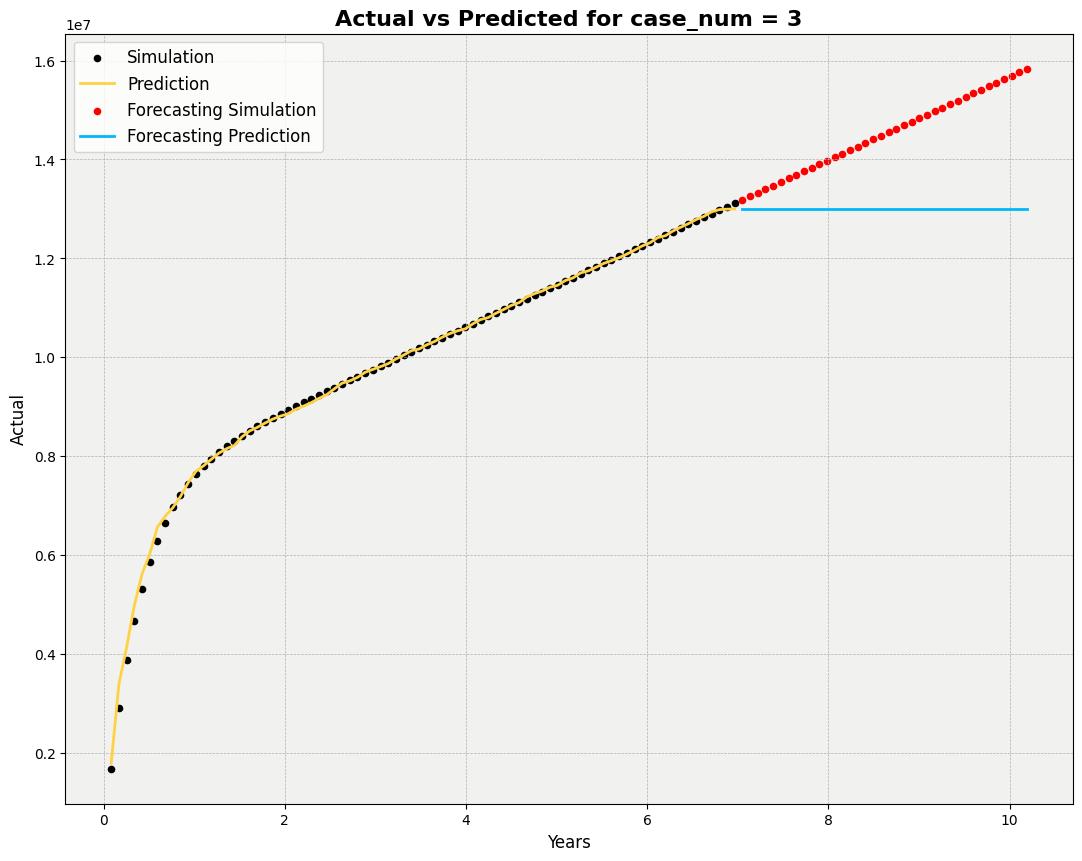

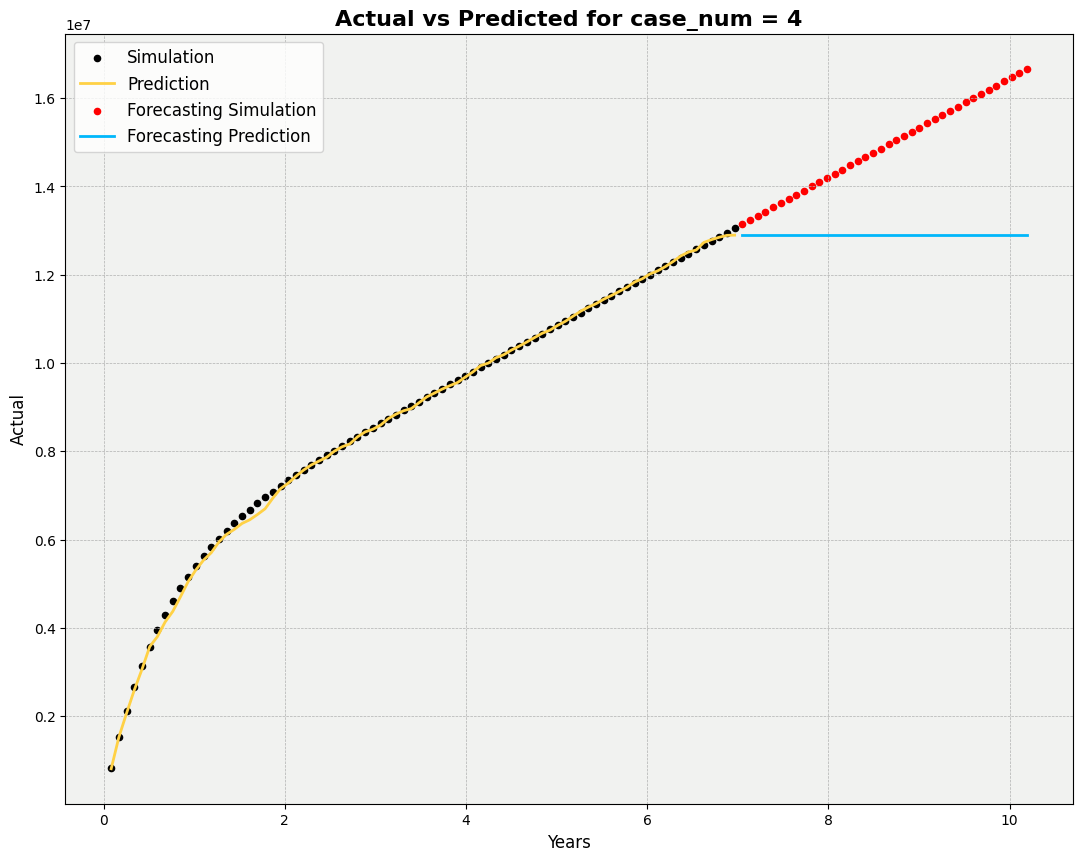

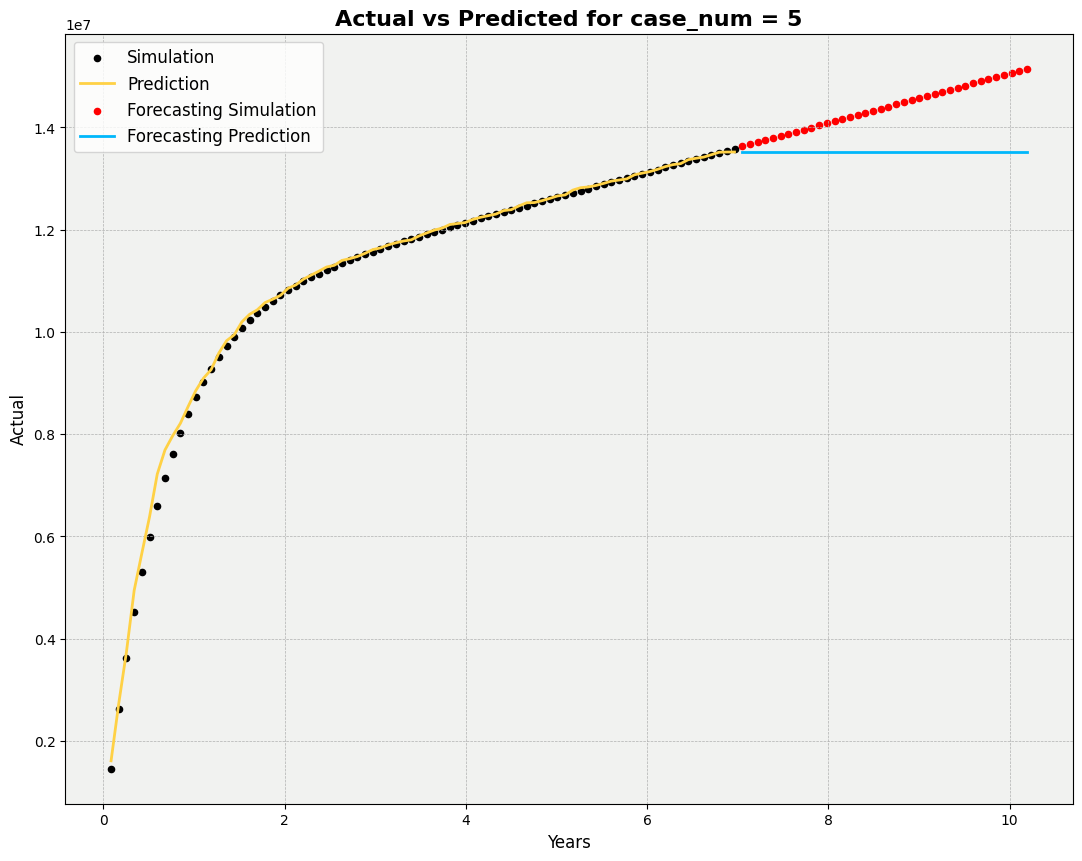

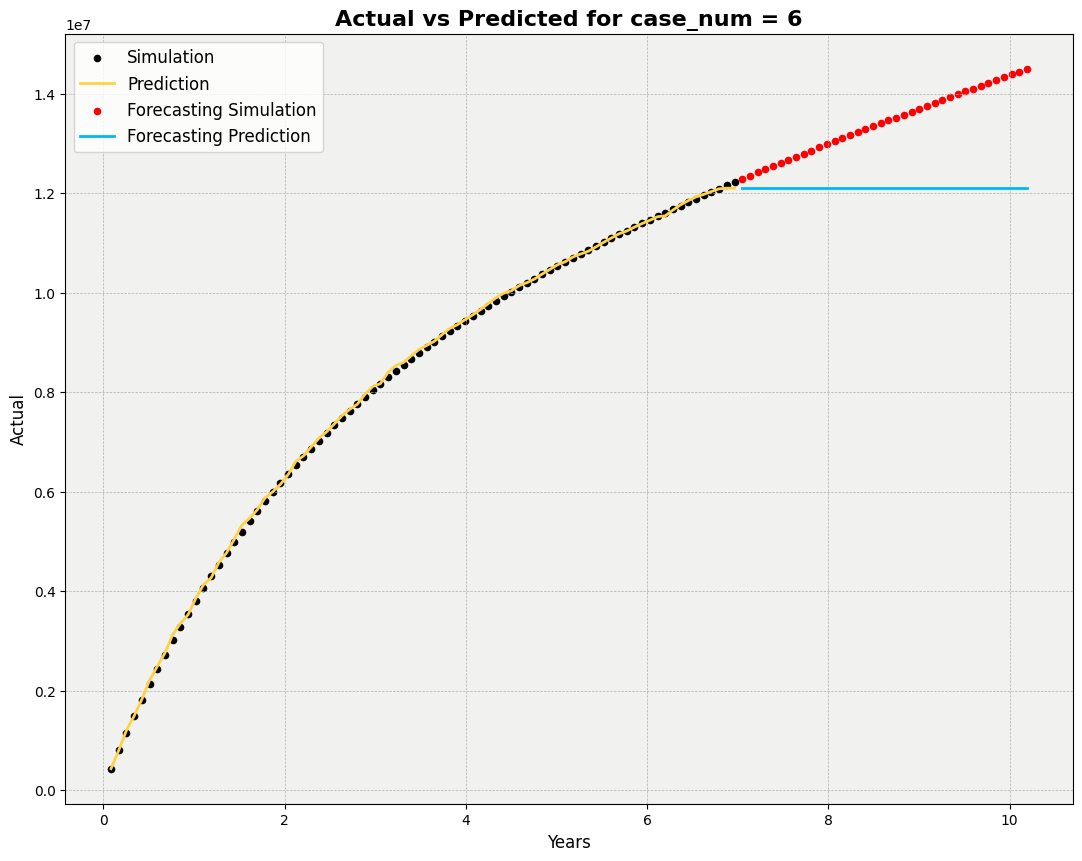

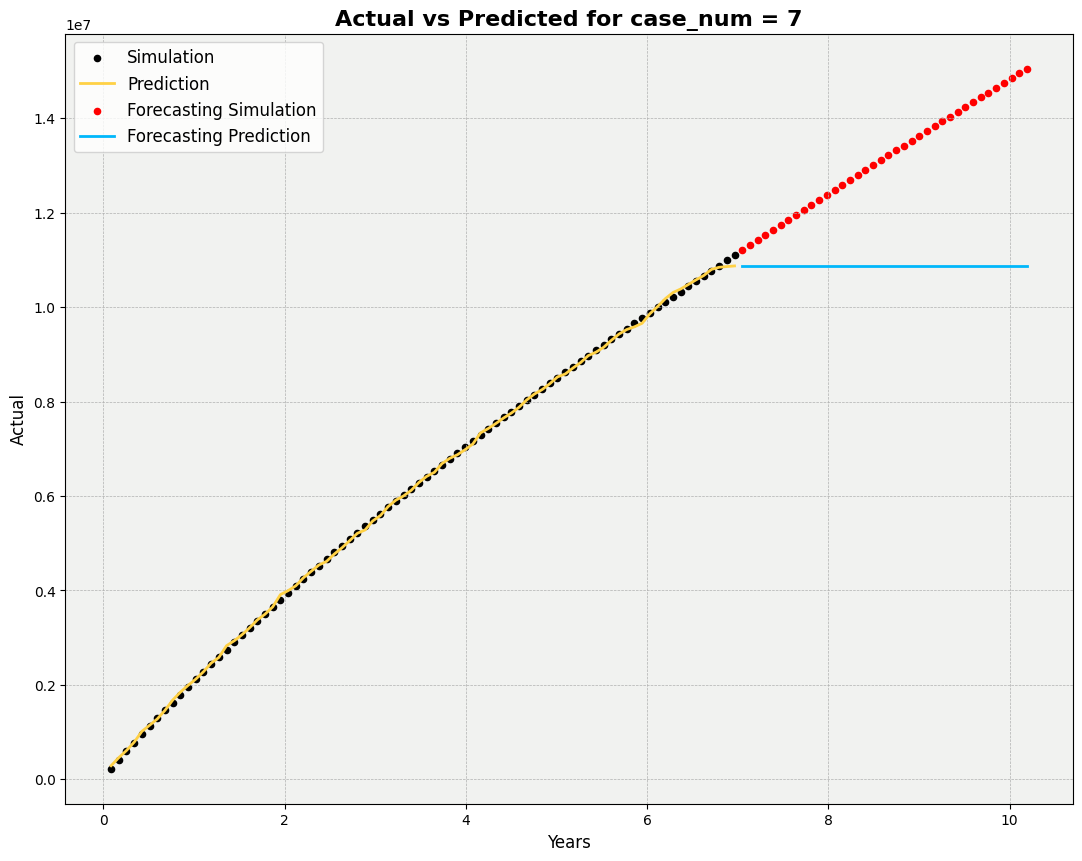

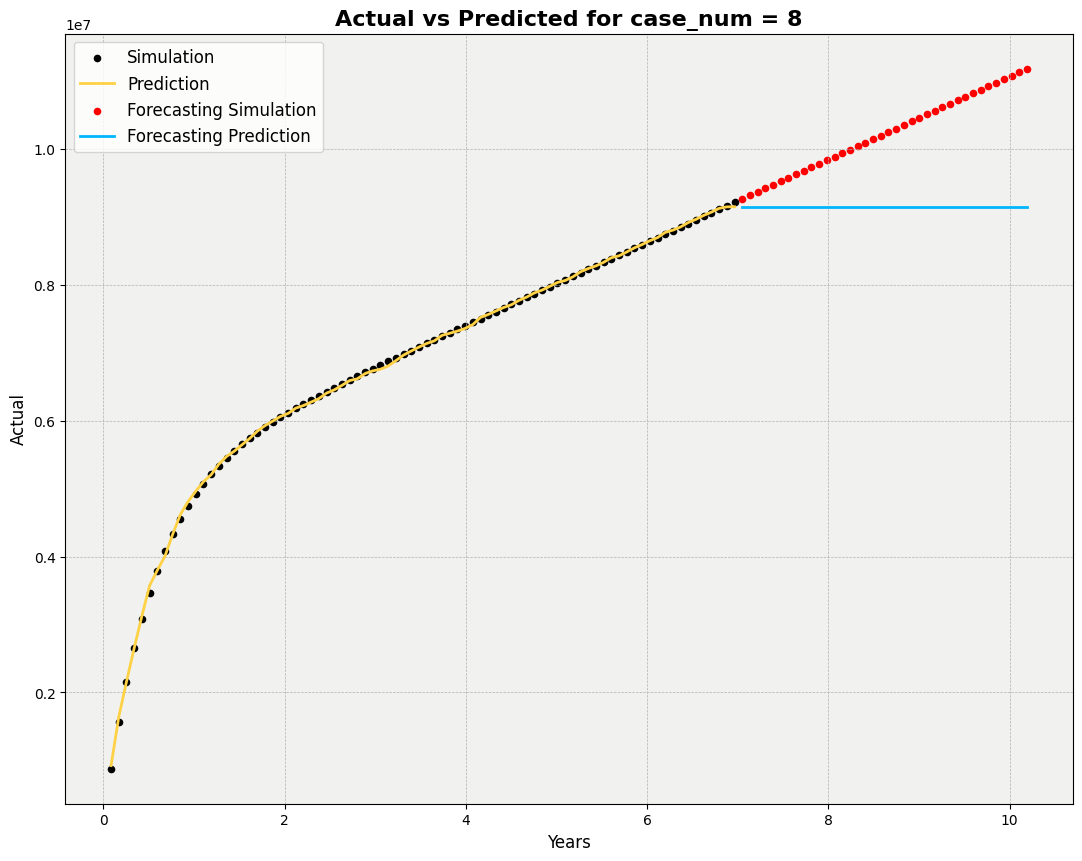

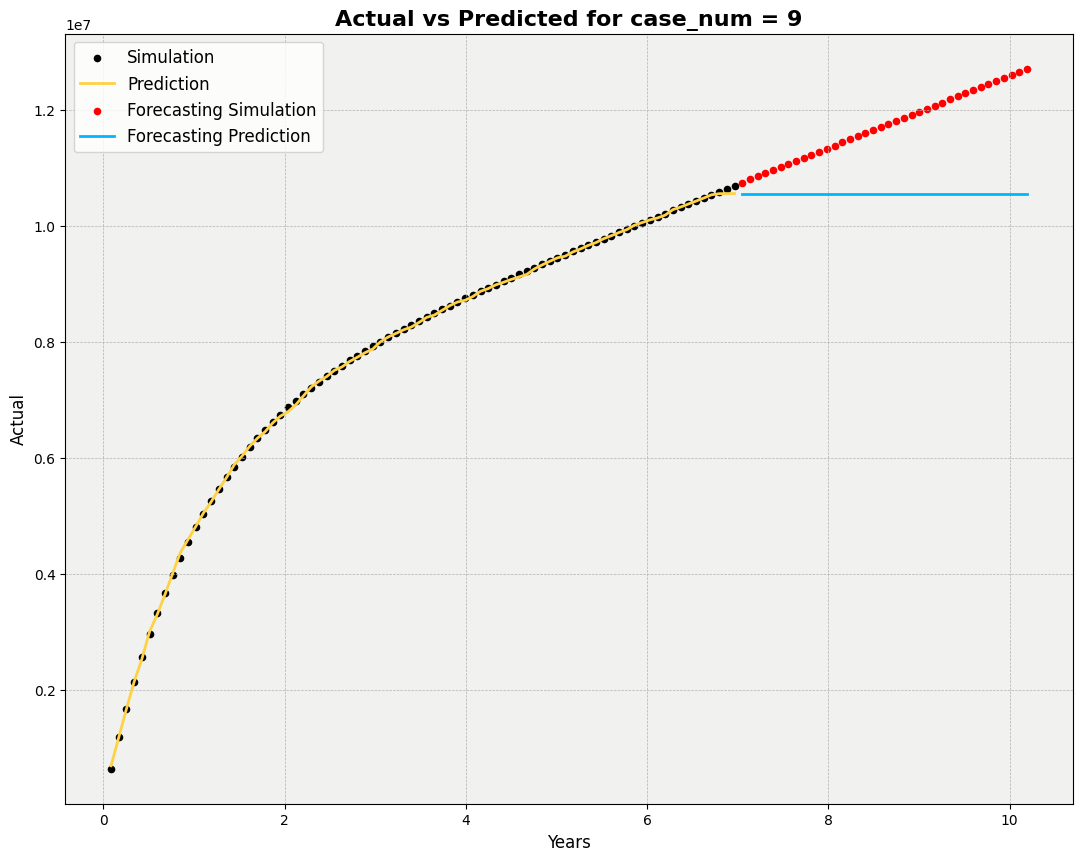

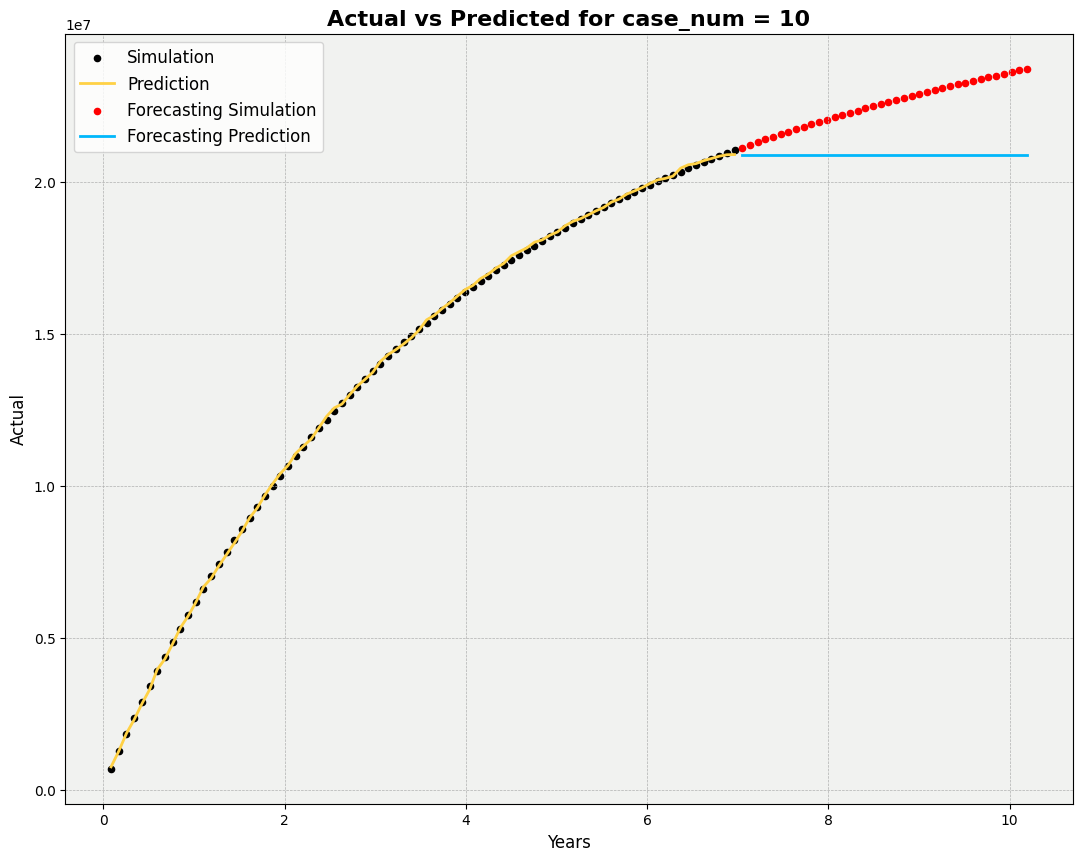

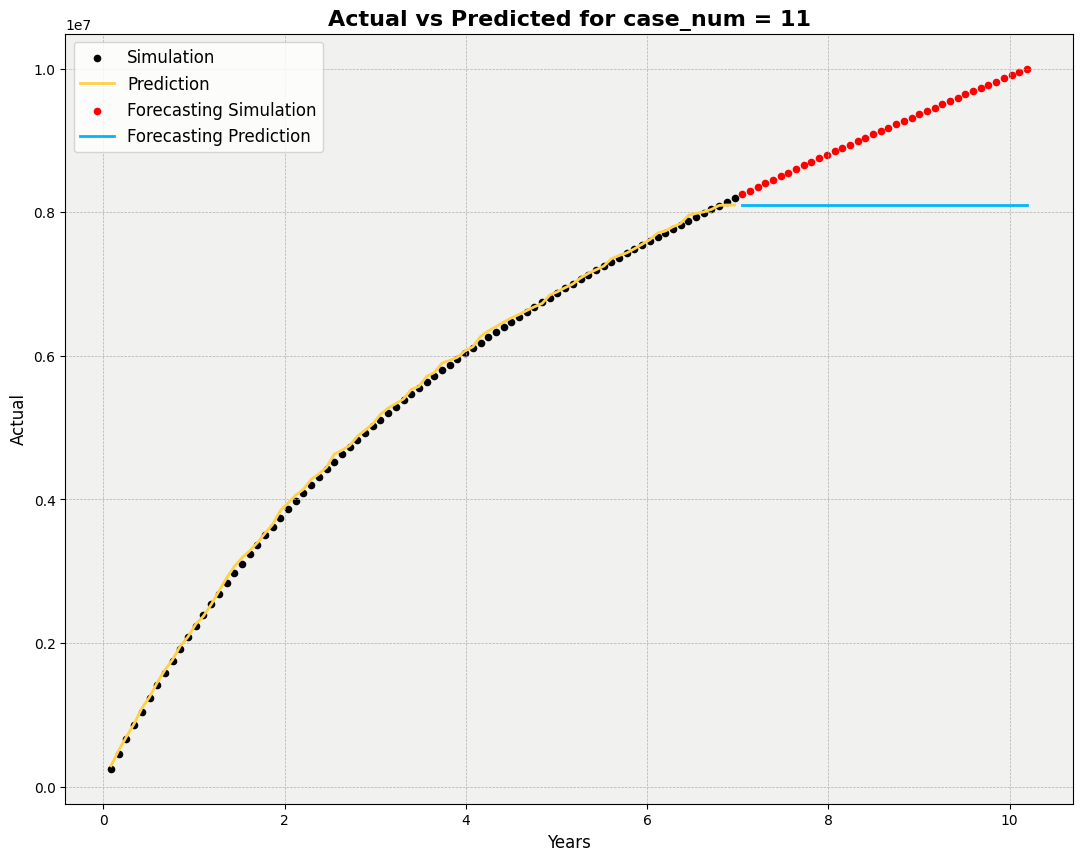

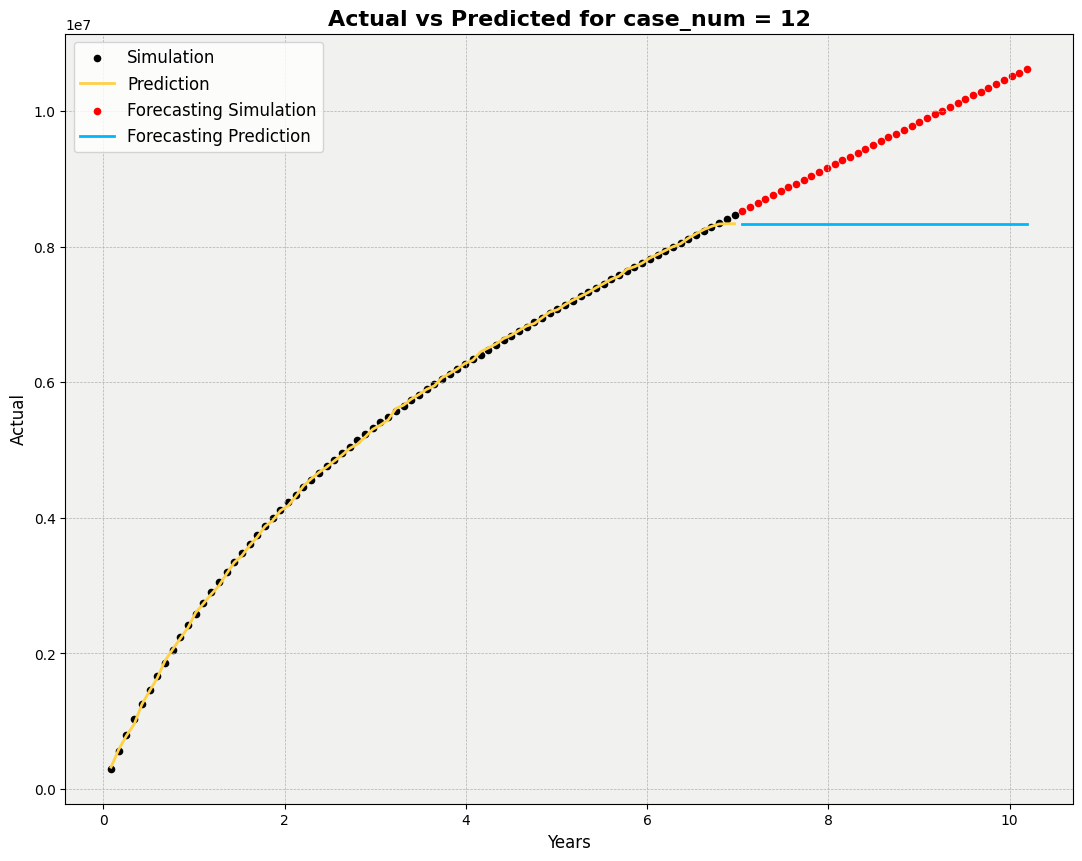

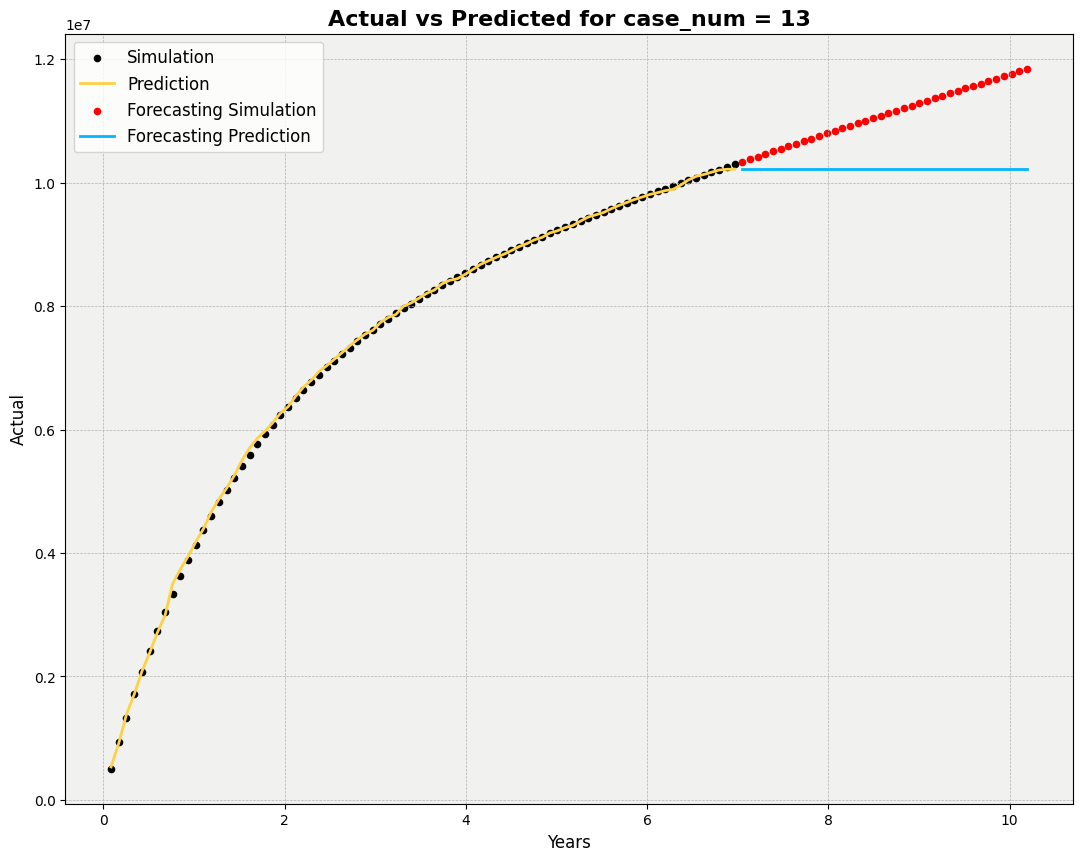

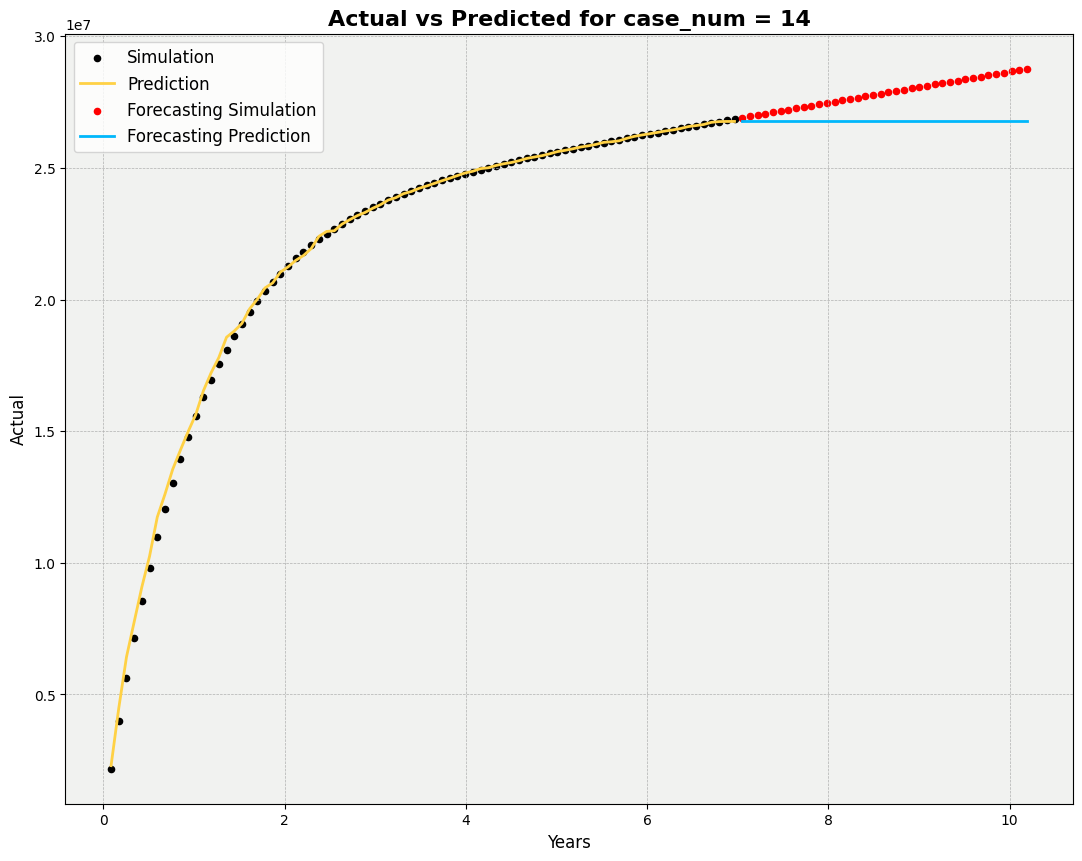

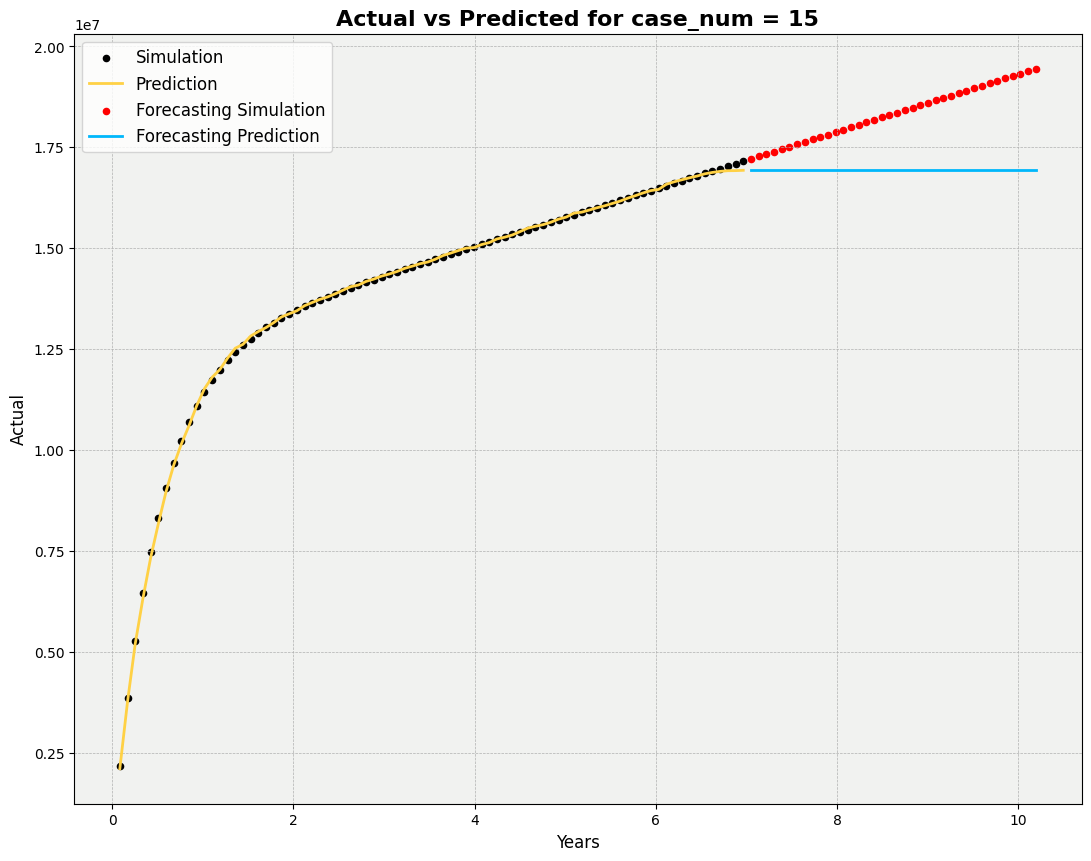

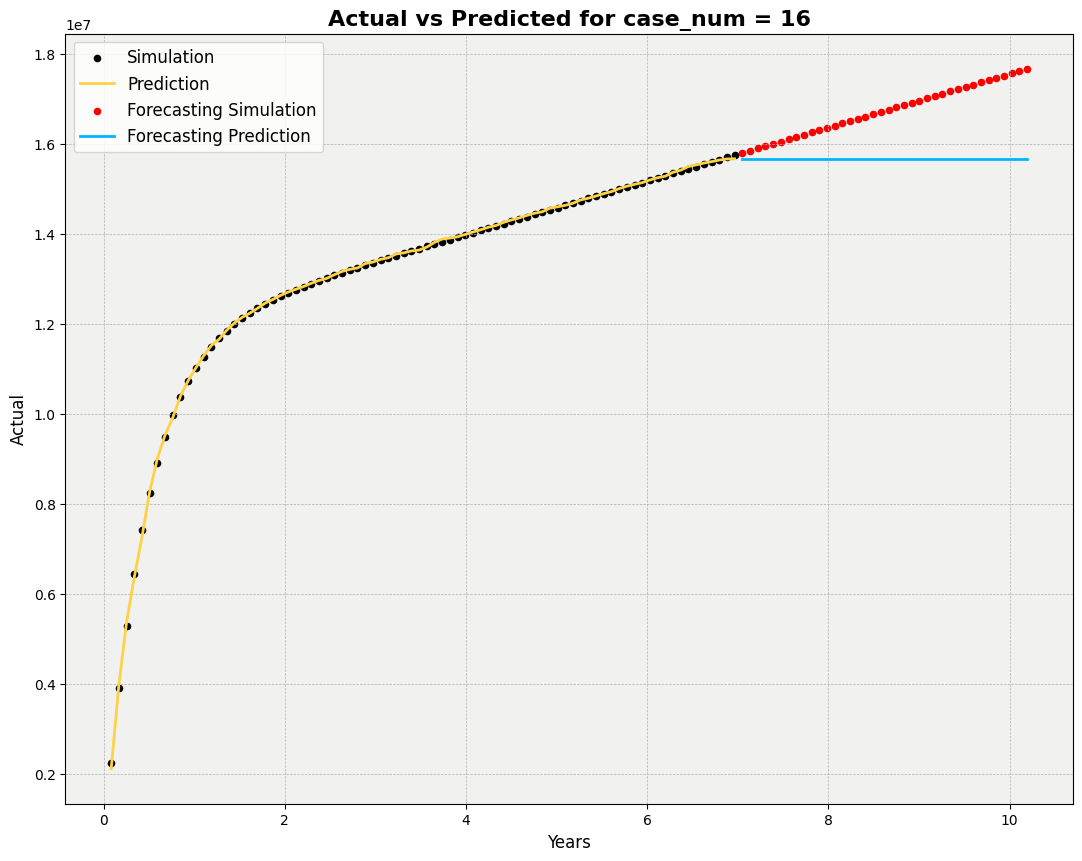

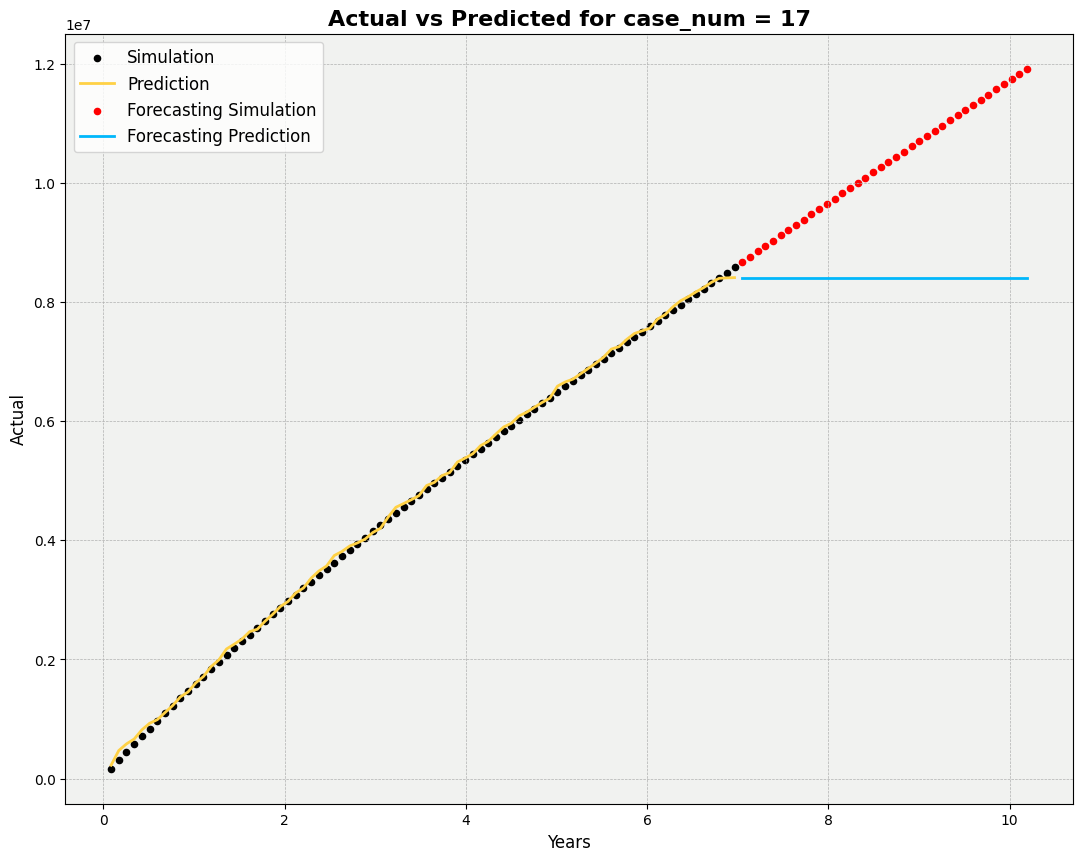

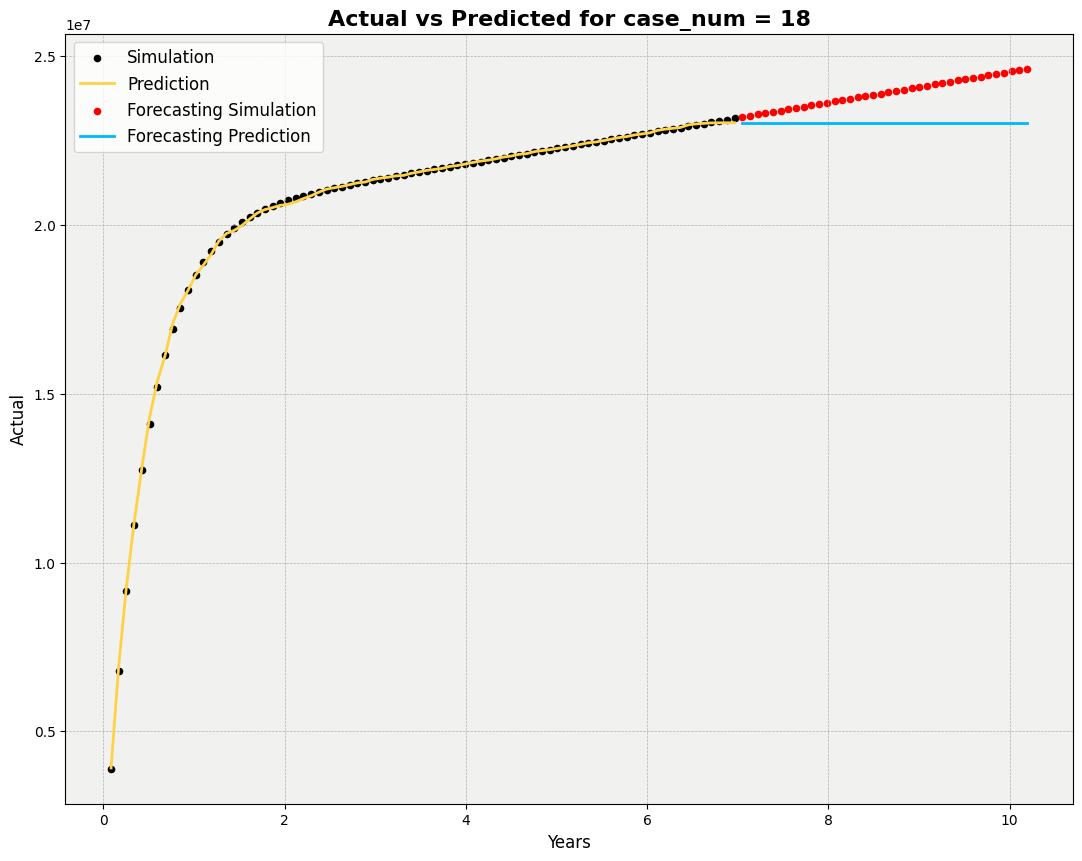

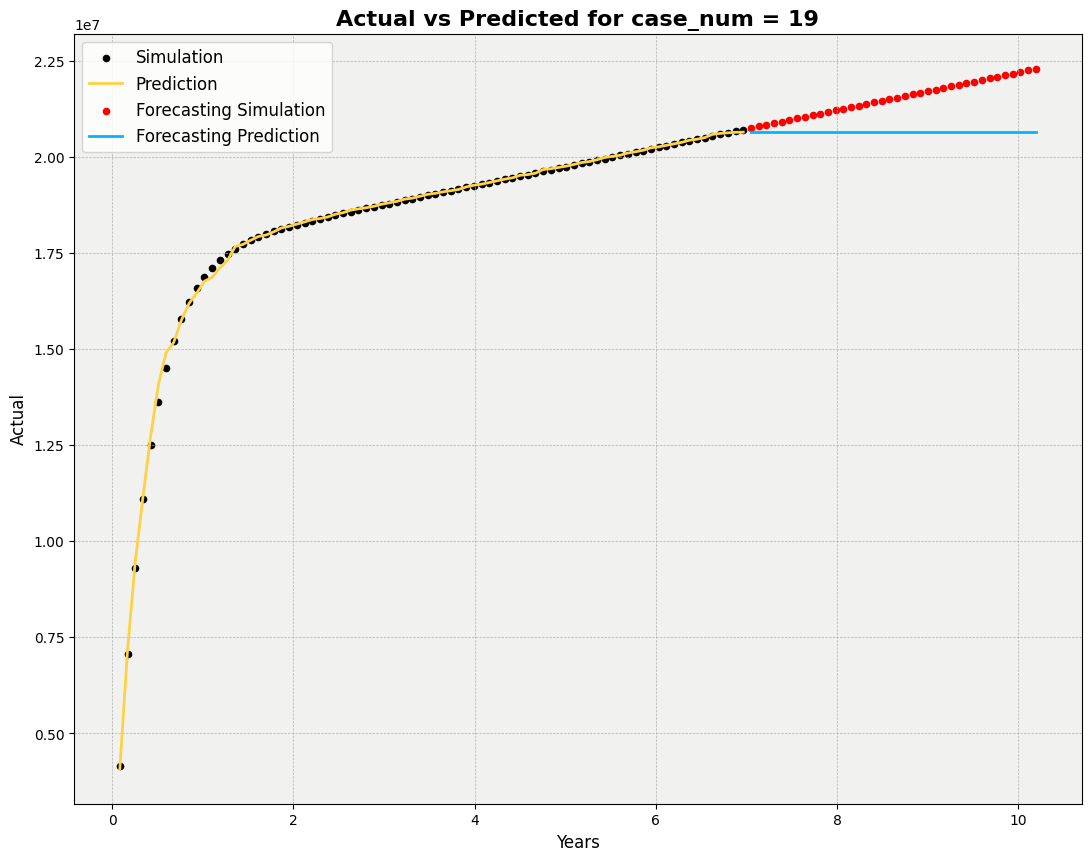

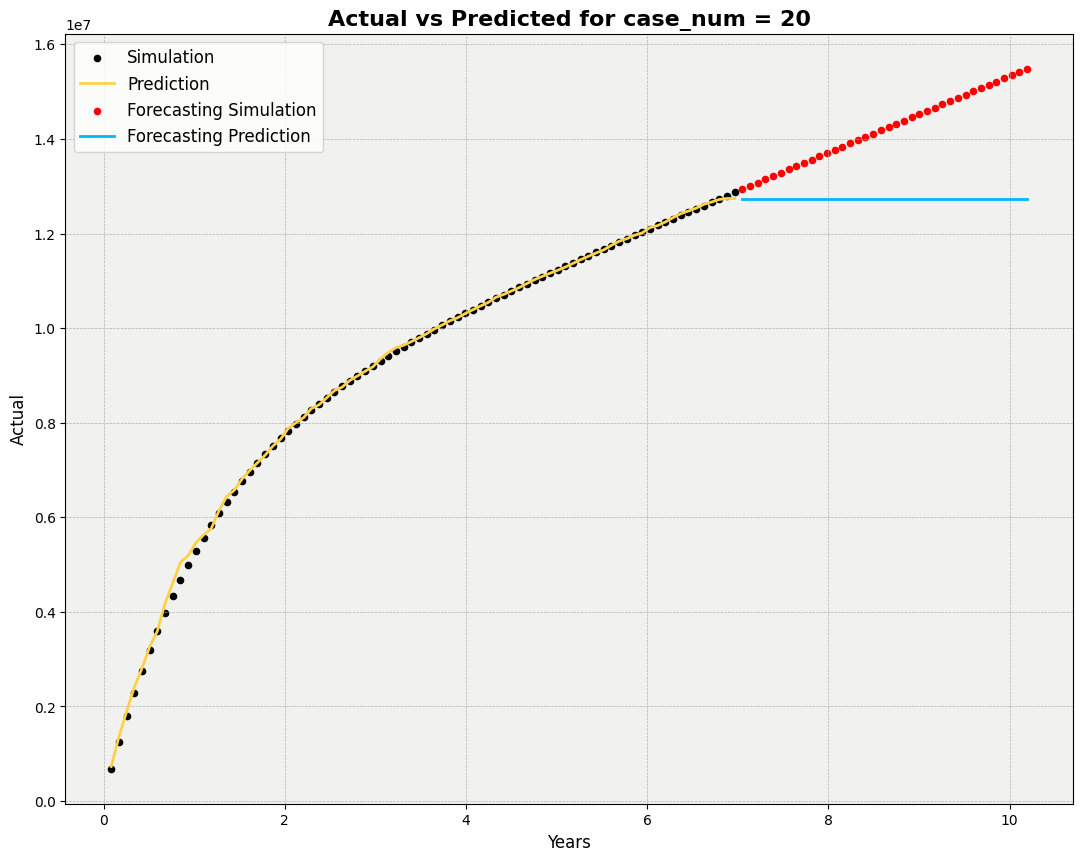

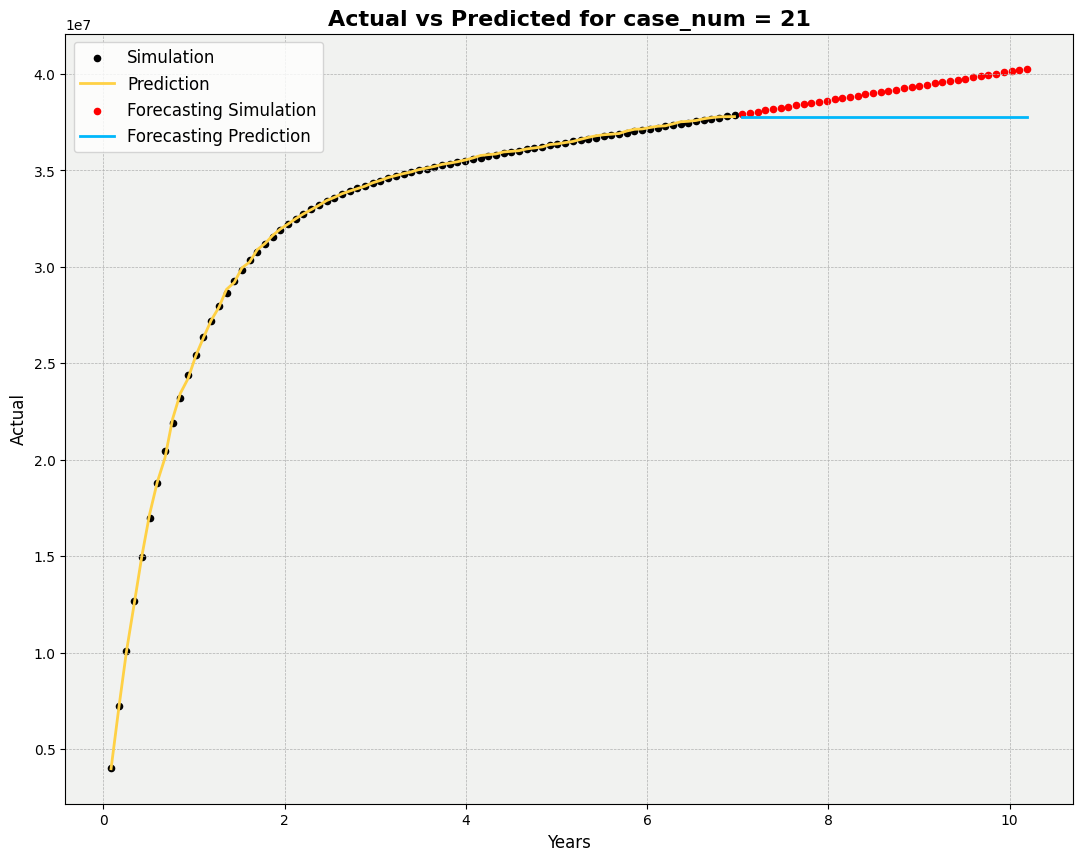

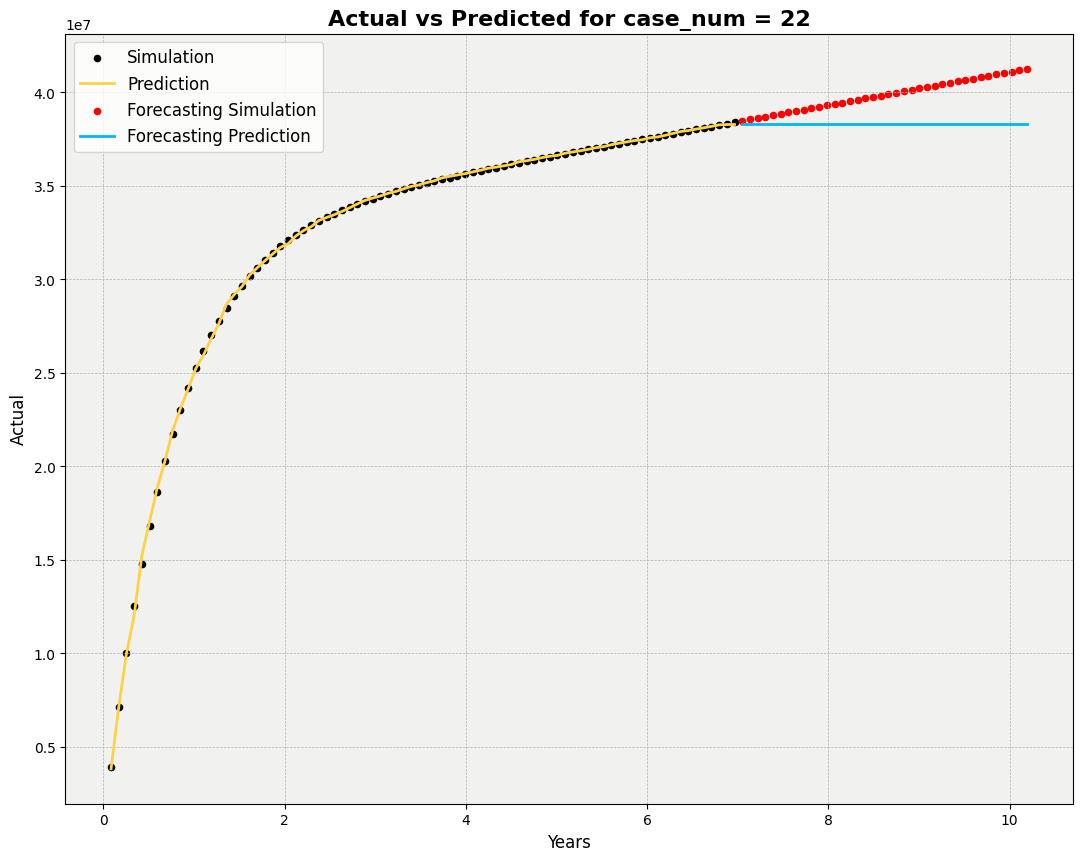

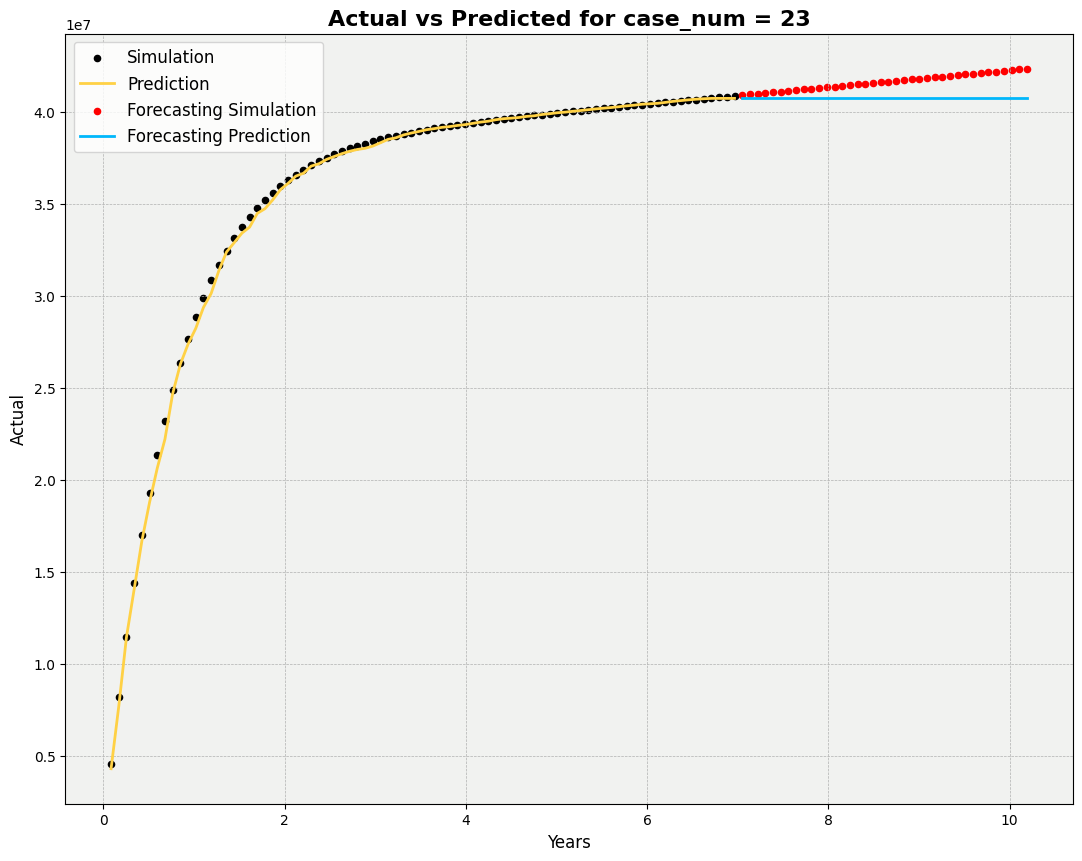

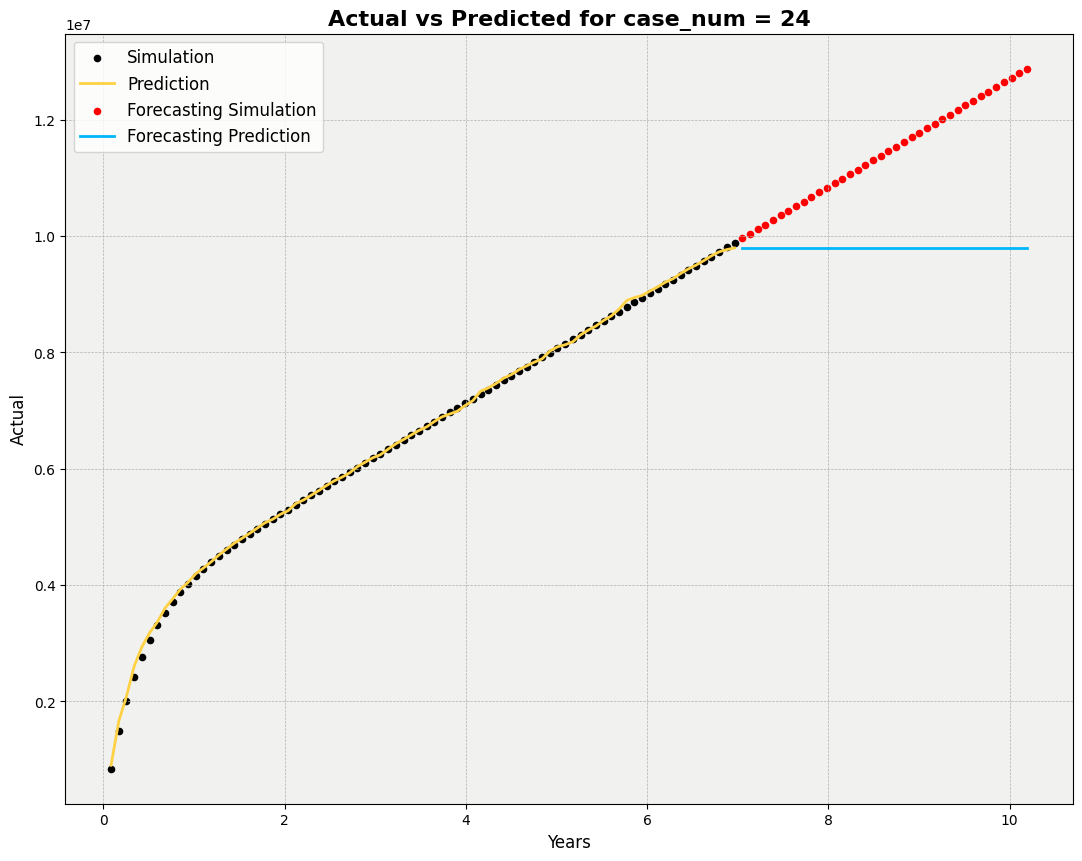

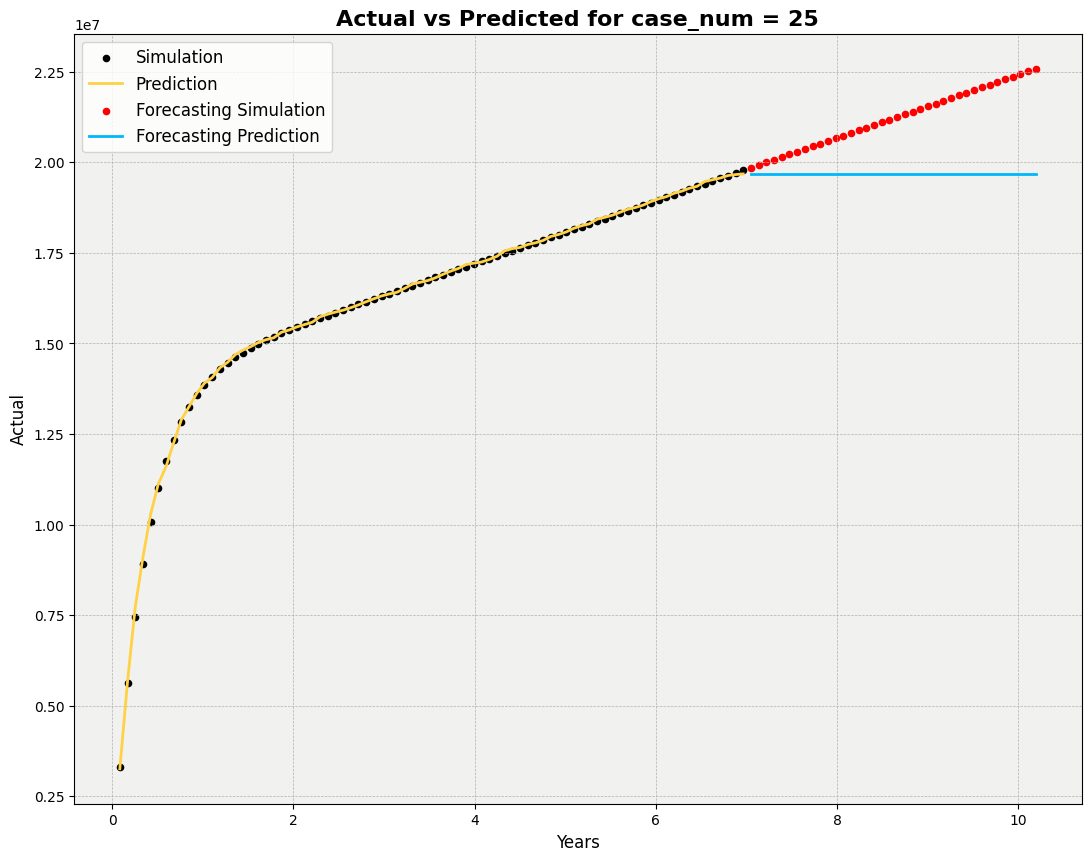

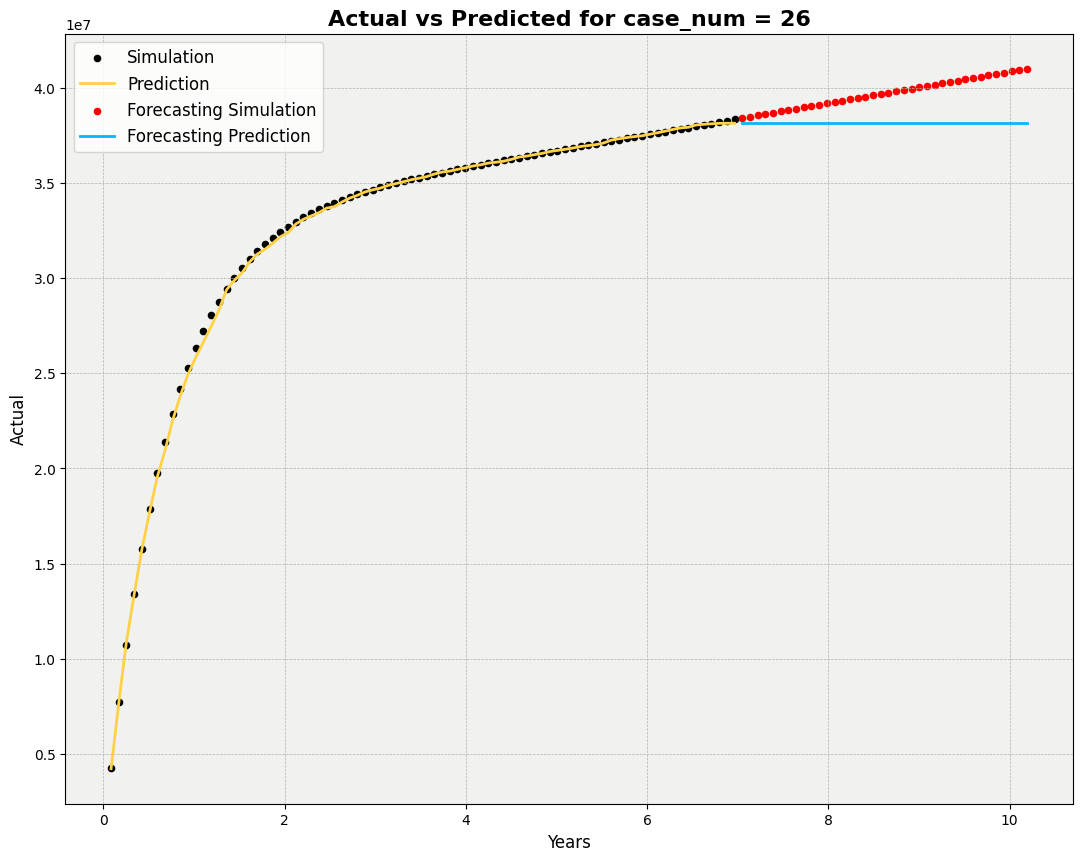

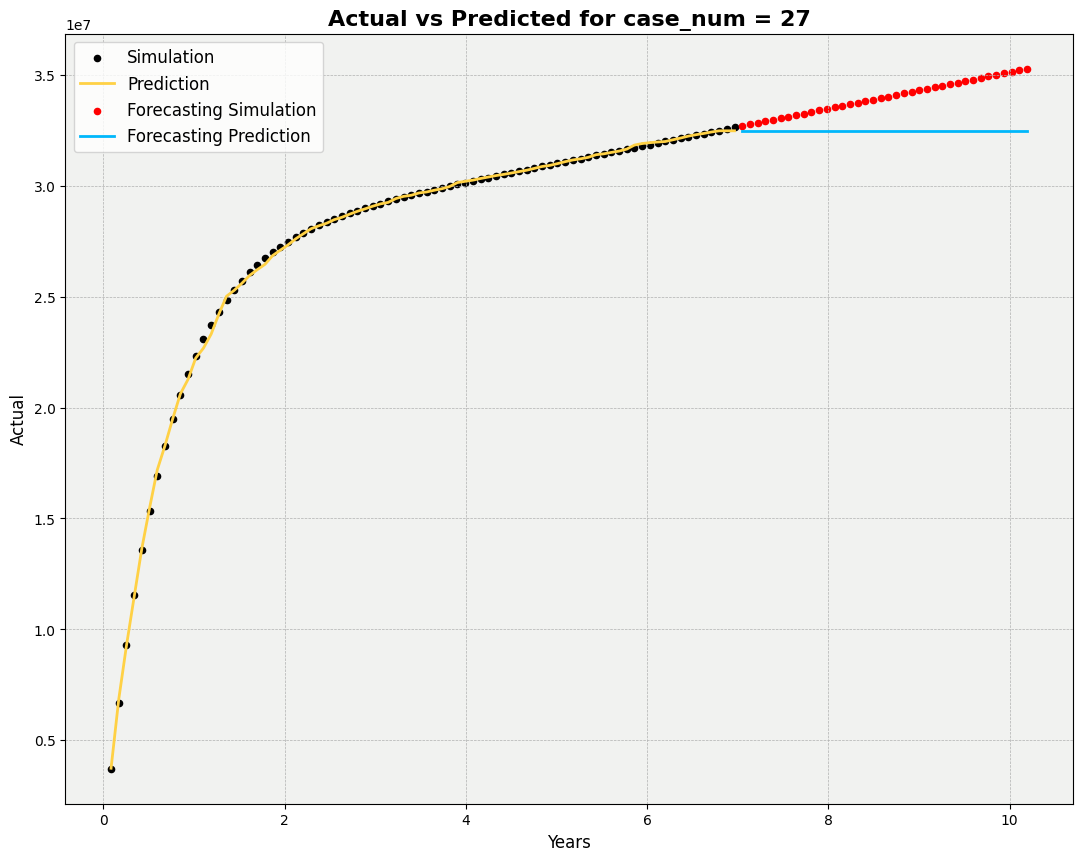

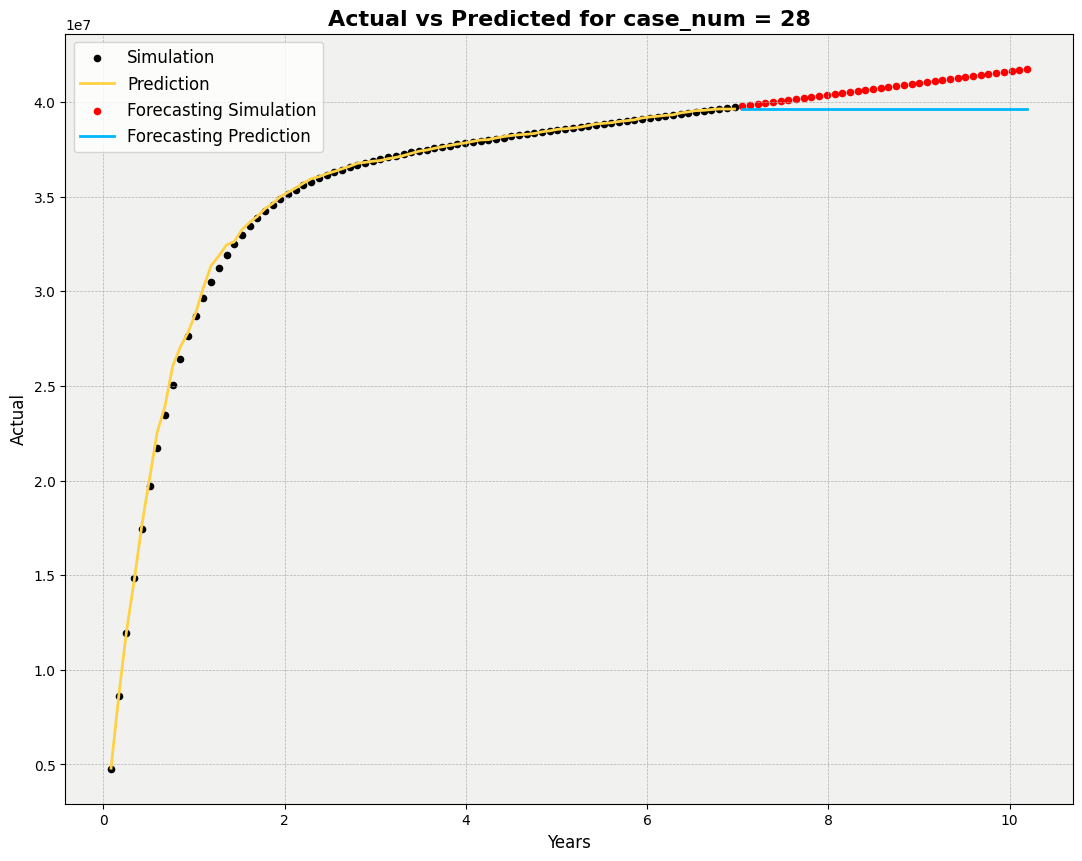

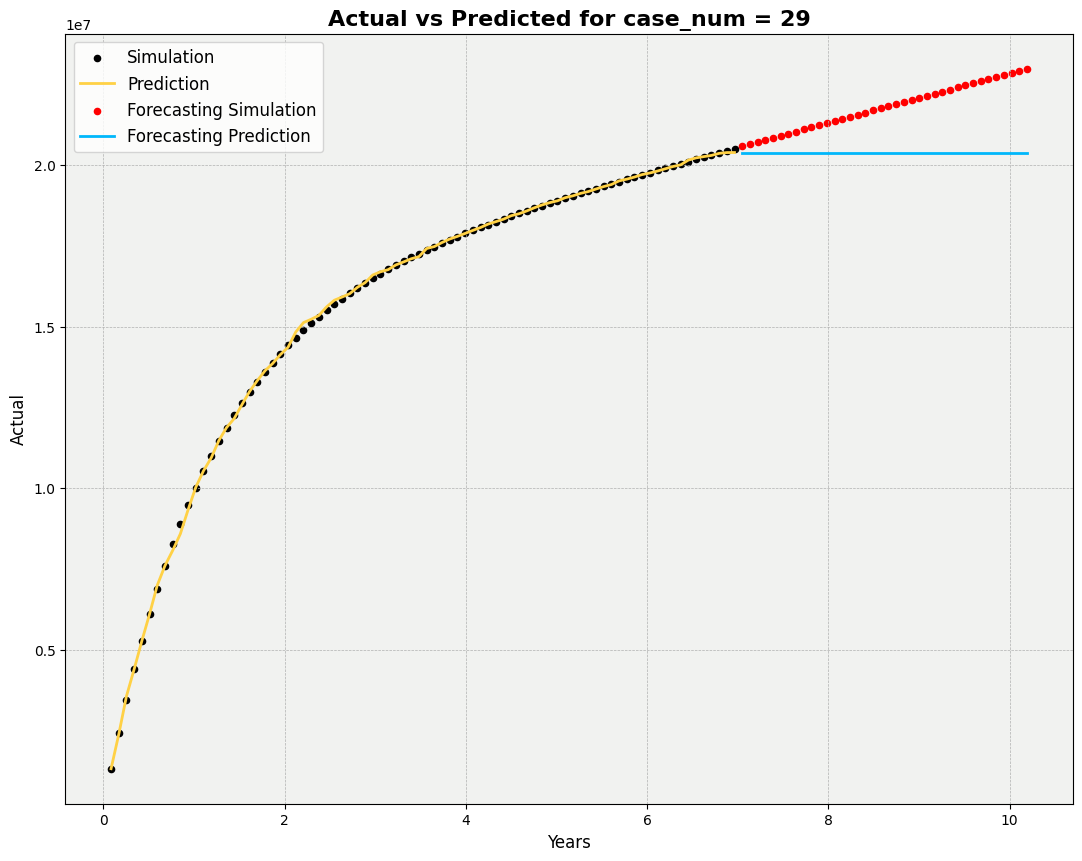

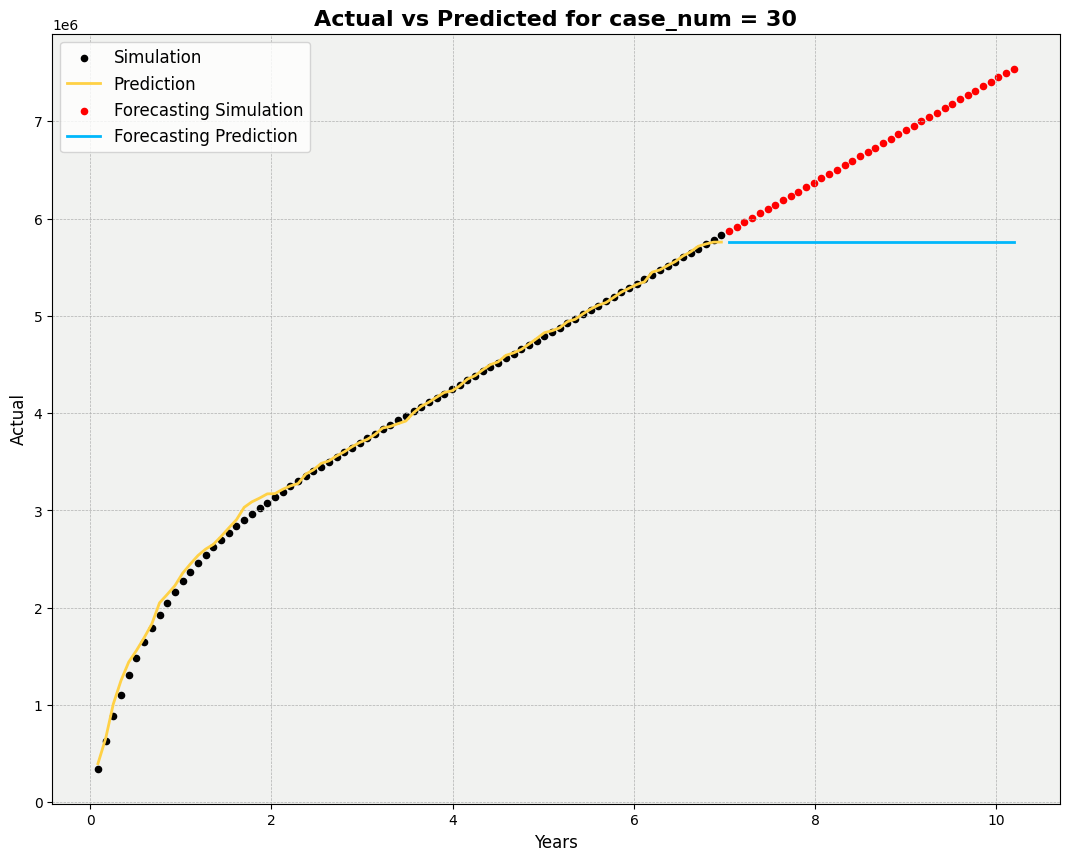

KeyboardInterrupt: ignored

In [322]:
# Get unique values in the "case_num" column
unique_cases = df_prediction2['case_num'].unique()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    plot_1 = df_prediction2[df_prediction2['case_num'] == case]
    plot_2 = val_pred[val_pred['case_num'] == case]
    
    # Create a new figure for each case_num
    fig, ax1 = plt.subplots(figsize=(13, 10))
    
    # Plot1 scatter for "Actual" column
    ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Simulation', marker='o')

    # Plot1 line for "Predicted" column
    ax1.plot(plot_1['years'], plot_1['Predicted'], color='#ffd145', linewidth=2, label='Prediction')


    # Plot2 scatter for "Actual" column
    ax1.scatter(plot_2['years'], plot_2['oil_prod_cum'], color='red', s=20, label='Forecasting Simulation', marker='o')

    # Plot2 line for "Predicted" column
    ax1.plot(plot_2['years'], plot_2['Predicted_cum_oil'], color='#00b7fb', linewidth=2, label='Forecasting Prediction')


    ax1.set_xlabel('Years', fontsize=12)
    ax1.set_ylabel('Actual', fontsize=12)

    # Add gridlines
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Customize the title font size and style
    plt.title(f'Actual vs Predicted for case_num = {case}', fontsize=16, fontweight='bold')

    # Customize the legend font size
    plt.legend(loc='upper left', fontsize=12)

    # Customize the tick label font size
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add a background color
    ax1.set_facecolor('#F1F2F0')

    plt.show()

In [200]:
# Bad result is found in the case [17, 11, 7, 6, 1]